In [33]:
%load_ext autoreload
%autoreload 2

# Manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve

# Helper functions
import os
#os.chdir('../')
from src.models import light_gbm

plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
df = pd.read_csv('data/processed/cleaned_data.csv')
df.head()

df2 = pd.read_csv('data/processed/collisions_and_intersections_cleaned.csv')
df2.head()

/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,INCKEY,INTKEY,AAWDT,YEAR,ARTERIALCLASSCD,SIGNAL_TYPE,LOCATION,SUBAREA,WEATHER_Adverse,WEATHER_Good,WEATHER_Unknown,ROADCOND_Adverse,ROADCOND_Dry,ROADCOND_Unknown,LIGHTCOND_Dark,LIGHTCOND_Daylight,LIGHTCOND_Unknown,LIGHTCOND_VeryDark,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SEVERITYCODE_Injury,FATALITIES,SERIOUSINJURIES,INJURIES,UNDERINFL
0,0,68113,29745.0,18200.0,2007,2.0,CITY,BROADWAY AND E PIKE ST,E,0,1,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,0
1,1,72837,29745.0,18200.0,2007,2.0,CITY,BROADWAY AND E PIKE ST,E,0,1,0,1,0,0,0,1,0,0,0,0,2,0,0,0,0,0
2,2,77625,29745.0,18200.0,2007,2.0,CITY,BROADWAY AND E PIKE ST,E,0,1,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0
3,3,70824,29745.0,18200.0,2007,2.0,CITY,BROADWAY AND E PIKE ST,E,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0
4,4,70744,29745.0,18200.0,2007,2.0,CITY,BROADWAY AND E PIKE ST,E,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0


In [35]:
# Drop columns and check NaN
to_drop = ['Datetime', 'X', 'Y', 'OBJECTID', 'INCKEY', 'ADDRTYPE', 'LOCATION', 
           'INCDATE', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'ST_COLCODE', 'INTKEY',
           'PERSONCOUNT']
data = df.drop(columns=to_drop)
data.isnull().sum()

PEDCOUNT                       0
PEDCYLCOUNT                    0
VEHCOUNT                       0
INJURIES                       0
SERIOUSINJURIES                0
                              ..
LIGHTCOND_Unknown              0
LIGHTCOND_VeryDark             0
SEVERITYCODE_Injury            0
SEVERITYCODE_PropertyDamage    0
SEVERITYCODE_Unknown           0
Length: 25, dtype: int64

## Start the base model
1. Define target based on our business case
a. Binary injury/not injury, collisions with pedestrains/cyclists vs not, etc
2. Create train/test split
3. Train model
4. Evaluate metrics

#### All data

In [36]:
# Define our target. In this case can use severitycode_injury
data['SEVERITYCODE_Injury'].value_counts()/data.shape[0]

0    0.686543
1    0.313457
Name: SEVERITYCODE_Injury, dtype: float64

[1]	valid_0's binary_logloss: 0.621454
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.621027
[3]	valid_0's binary_logloss: 0.620119
[4]	valid_0's binary_logloss: 0.619332
[5]	valid_0's binary_logloss: 0.61841
[6]	valid_0's binary_logloss: 0.617517
[7]	valid_0's binary_logloss: 0.616767
[8]	valid_0's binary_logloss: 0.615951
[9]	valid_0's binary_logloss: 0.615087
[10]	valid_0's binary_logloss: 0.614254
[11]	valid_0's binary_logloss: 0.613448
[12]	valid_0's binary_logloss: 0.612642
[13]	valid_0's binary_logloss: 0.611843
[14]	valid_0's binary_logloss: 0.611064
[15]	valid_0's binary_logloss: 0.610359
[16]	valid_0's binary_logloss: 0.60961
[17]	valid_0's binary_logloss: 0.608877
[18]	valid_0's binary_logloss: 0.608167
[19]	valid_0's binary_logloss: 0.607462
[20]	valid_0's binary_logloss: 0.606844
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.606844


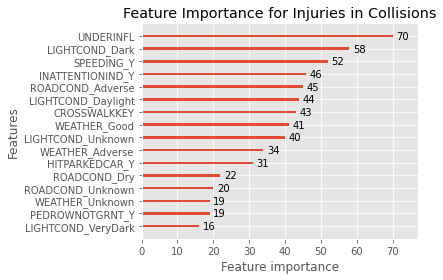

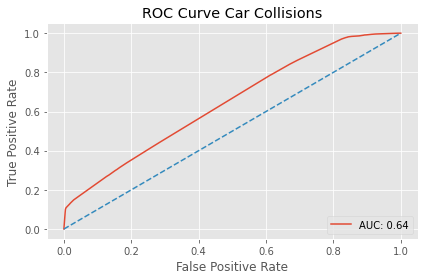

In [102]:
# Get X and y for model
y = data['SEVERITYCODE_Injury']
X = data.drop(columns=['SEVERITYCODE_Injury', 'SEVERITYCODE_Unknown', 
                       'SEVERITYCODE_PropertyDamage', 'INJURIES', 
                       'SERIOUSINJURIES', 'FATALITIES', 'VEHCOUNT',
                      'PEDCYLCOUNT', 'PEDCOUNT'])

X_train, X_test, y_train, y_test = train_test_split(X,y)

# Run model (this includes doing train/test split)
names_all, importances_all = light_gbm.light_gbm(X_train, X_test, y_train, y_test, 
                         name='Injuries in Collisions')

#### Ped/cyclists only

In [66]:
### Look at pedestrian/cyclist collisions only
pedcycle = data.loc[(data['PEDCYLCOUNT'] != 0) | (data['PEDCOUNT'] !=0)]
print(pedcycle.shape[0]/data.shape[0])
pedcycle['SEVERITYCODE_Injury'].value_counts()/pedcycle.shape[0]

0.07153738471673254


1    0.900288
0    0.099712
Name: SEVERITYCODE_Injury, dtype: float64

In [38]:
pedcycle.columns

Index(['PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'UNDERINFL', 'CROSSWALKKEY', 'SPEEDING_Y',
       'INATTENTIONIND_Y', 'HITPARKEDCAR_Y', 'PEDROWNOTGRNT_Y',
       'WEATHER_Adverse', 'WEATHER_Good', 'WEATHER_Unknown',
       'ROADCOND_Adverse', 'ROADCOND_Dry', 'ROADCOND_Unknown',
       'LIGHTCOND_Dark', 'LIGHTCOND_Daylight', 'LIGHTCOND_Unknown',
       'LIGHTCOND_VeryDark', 'SEVERITYCODE_Injury',
       'SEVERITYCODE_PropertyDamage', 'SEVERITYCODE_Unknown'],
      dtype='object')

[1]	valid_0's binary_logloss: 0.322819
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.322777
[3]	valid_0's binary_logloss: 0.322754
[4]	valid_0's binary_logloss: 0.322715
[5]	valid_0's binary_logloss: 0.322704
[6]	valid_0's binary_logloss: 0.322619
[7]	valid_0's binary_logloss: 0.322554
[8]	valid_0's binary_logloss: 0.322458
[9]	valid_0's binary_logloss: 0.322384
[10]	valid_0's binary_logloss: 0.322313
[11]	valid_0's binary_logloss: 0.322259
[12]	valid_0's binary_logloss: 0.322204
[13]	valid_0's binary_logloss: 0.322133
[14]	valid_0's binary_logloss: 0.322081
[15]	valid_0's binary_logloss: 0.322048
[16]	valid_0's binary_logloss: 0.321976
[17]	valid_0's binary_logloss: 0.321916
[18]	valid_0's binary_logloss: 0.321849
[19]	valid_0's binary_logloss: 0.321793
[20]	valid_0's binary_logloss: 0.321707
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.321707


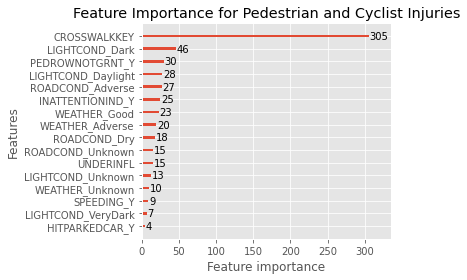

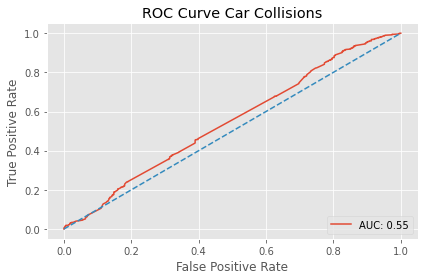

In [87]:
# Get X and y
y = pedcycle['SEVERITYCODE_Injury']
X = pedcycle.drop(columns=['SEVERITYCODE_Injury', 'SEVERITYCODE_Unknown', 
                           'SEVERITYCODE_PropertyDamage', 'INJURIES', 
                           'SERIOUSINJURIES', 'FATALITIES','PEDCYLCOUNT', 
                           'PEDCOUNT', 'VEHCOUNT'])
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Run model
names_ped, importances_ped = light_gbm.light_gbm(X_train, X_test, y_train, y_test, 
                         name='Pedestrian and Cyclist Injuries')

#### No Pedestrians or Cyclists

In [68]:
no_pedcycle = data.loc[(data['PEDCYLCOUNT'] == 0) & (data['PEDCOUNT'] == 0)]
print(no_pedcycle.shape[0]/data.shape[0])
no_pedcycle['SEVERITYCODE_Injury'].value_counts()/no_pedcycle.shape[0]

0.9284626152832675


0    0.731758
1    0.268242
Name: SEVERITYCODE_Injury, dtype: float64

[1]	valid_0's binary_logloss: 0.580473
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.58014
[3]	valid_0's binary_logloss: 0.579737
[4]	valid_0's binary_logloss: 0.579338
[5]	valid_0's binary_logloss: 0.578943
[6]	valid_0's binary_logloss: 0.578621
[7]	valid_0's binary_logloss: 0.578242
[8]	valid_0's binary_logloss: 0.577861
[9]	valid_0's binary_logloss: 0.577544
[10]	valid_0's binary_logloss: 0.577205
[11]	valid_0's binary_logloss: 0.576844
[12]	valid_0's binary_logloss: 0.576481
[13]	valid_0's binary_logloss: 0.57618
[14]	valid_0's binary_logloss: 0.575835
[15]	valid_0's binary_logloss: 0.575508
[16]	valid_0's binary_logloss: 0.575173
[17]	valid_0's binary_logloss: 0.574844
[18]	valid_0's binary_logloss: 0.574519
[19]	valid_0's binary_logloss: 0.574213
[20]	valid_0's binary_logloss: 0.573904
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.573904


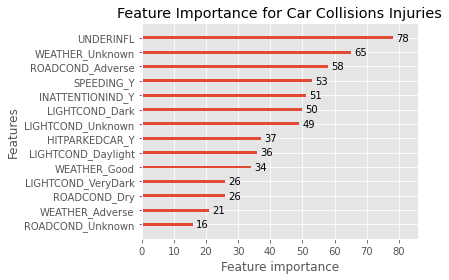

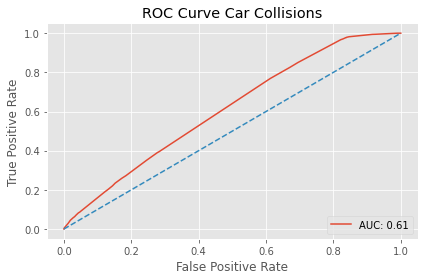

In [91]:
# Get X and y
y = no_pedcycle['SEVERITYCODE_Injury']
X = no_pedcycle.drop(columns=['SEVERITYCODE_Injury', 'SEVERITYCODE_Unknown', 
                           'SEVERITYCODE_PropertyDamage', 'INJURIES', 
                           'SERIOUSINJURIES', 'FATALITIES','PEDCYLCOUNT', 
                           'PEDCOUNT', 'VEHCOUNT'])
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Run model
names_car, importances_car = light_gbm.light_gbm(X_train, X_test, y_train, y_test, 
                         name='Car Collisions Injuries')

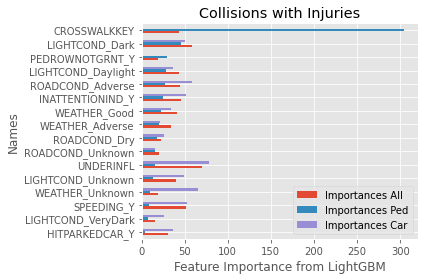

In [129]:
# Plotting all importances
df1 = pd.DataFrame({'Names': names_all, 'Importances All': importances_all})
df2 = pd.DataFrame({'Names': names_ped, 'Importances Ped': importances_ped})
df3 = pd.DataFrame({'Names': names_car, 'Importances Car': importances_car})

# Merge
df_combined = (
    pd.merge(pd.merge(df1, df2, how='outer', on='Names'), 
             df3, how='outer', on='Names')
    .set_index('Names')
    .sort_values(by='Importances Ped', ascending=True)
     )

# Plot
df_combined.plot(kind='barh')
plt.title('Collisions with Injuries')
plt.xlabel('Feature Importance from LightGBM')
plt.tight_layout()
plt.savefig('reports/figures/combined_importances_lgb.png', bbox_inches='tight')

## Code Testing
This has been ported into source .py file

In [61]:
# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify configuration
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
}

gbm = lgb.train(params, 
                lgb_train, 
                num_boost_round=20, 
                valid_sets=lgb_eval, 
                early_stopping_rounds=5)

gbm.save_model('lgbm_model.txt')

[1]	valid_0's binary_logloss: 0.621279
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.620008
[3]	valid_0's binary_logloss: 0.618497
[4]	valid_0's binary_logloss: 0.616937
[5]	valid_0's binary_logloss: 0.61563
[6]	valid_0's binary_logloss: 0.614731
[7]	valid_0's binary_logloss: 0.613614
[8]	valid_0's binary_logloss: 0.612363
[9]	valid_0's binary_logloss: 0.61094
[10]	valid_0's binary_logloss: 0.609961
[11]	valid_0's binary_logloss: 0.608602
[12]	valid_0's binary_logloss: 0.607269
[13]	valid_0's binary_logloss: 0.606202
[14]	valid_0's binary_logloss: 0.605233
[15]	valid_0's binary_logloss: 0.604213
[16]	valid_0's binary_logloss: 0.603143
[17]	valid_0's binary_logloss: 0.602011
[18]	valid_0's binary_logloss: 0.600873
[19]	valid_0's binary_logloss: 0.599823
[20]	valid_0's binary_logloss: 0.598762
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.598762


(['PEDCOUNT',
  'PEDCYLCOUNT',
  'VEHCOUNT',
  'UNDERINFL',
  'CROSSWALKKEY',
  'SPEEDING_Y',
  'INATTENTIONIND_Y',
  'HITPARKEDCAR_Y',
  'PEDROWNOTGRNT_Y',
  'WEATHER_Adverse',
  'WEATHER_Good',
  'WEATHER_Unknown',
  'ROADCOND_Adverse',
  'ROADCOND_Dry',
  'ROADCOND_Unknown',
  'LIGHTCOND_Dark',
  'LIGHTCOND_Daylight',
  'LIGHTCOND_Unknown',
  'LIGHTCOND_VeryDark'],
 array([13, 17, 61, 80, 13, 69, 41, 38, 18, 14, 17, 33, 33,  9, 26, 31, 45,
        31, 11], dtype=int32))

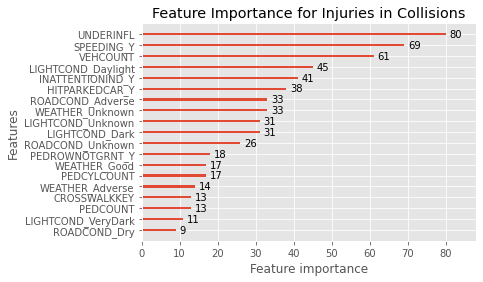

In [76]:
# Get feature importances for injury occuring in collision
test = lgb.plot_importance(gbm, title="Feature Importance for Injuries in Collisions")
gbm.feature_name(), gbm.feature_importance()

#plt.savefig('../reports/figures/lightgbm_importance_allcollisions.png')

In [63]:
# Do prediction and get AUC score
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
auc_score = roc_auc_score(y_test, y_pred)

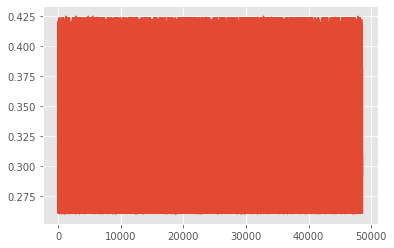

In [65]:
plt.plot(y_pred)

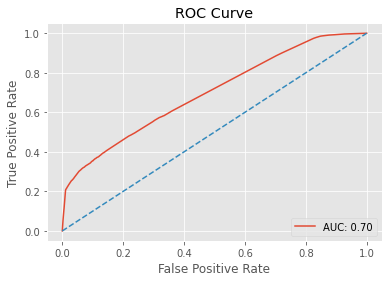

In [93]:
# Plot AUC 
# THIS LOOKS OFF -> INVESTIGATE
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='AUC: {:2.2f}'.format(auc_score))
ax.legend(loc='lower right')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
plt.savefig('reports/figures/lightgbm_auc.png')

In [38]:
thresholds

array([1.42475118, 0.42475118, 0.4238788 , 0.42371797, 0.42356321,
       0.42279256, 0.42189478, 0.42141843, 0.42117967, 0.42080065,
       0.42032464, 0.4201722 , 0.42012746, 0.41962668, 0.41957854,
       0.41920546, 0.41918528, 0.41913716, 0.41894934, 0.41888389,
       0.41870147, 0.41868087, 0.41836269, 0.41827698, 0.41779193,
       0.41767631, 0.41737527, 0.4173272 , 0.41712009, 0.41704927,
       0.41683218, 0.41619995, 0.41567643, 0.41545896, 0.41542722,
       0.41511942, 0.41505941, 0.41412915, 0.41399419, 0.41394291,
       0.41363342, 0.41353263, 0.41345946, 0.41327106, 0.4128616 ,
       0.4125145 , 0.41250865, 0.39890837, 0.39885727, 0.39771239,
       0.3977122 , 0.39760959, 0.39698328, 0.39678695, 0.39662135,
       0.39647337, 0.39632055, 0.39601814, 0.39584475, 0.39577047,
       0.39556495, 0.39439288, 0.39401707, 0.39308931, 0.39297633,
       0.39279717, 0.39209276, 0.39151543, 0.39144206, 0.39129476,
       0.39114264, 0.39102546, 0.39084163, 0.39072583, 0.39057